In [1]:
import pandas as pd

import sys
stdout = sys.stdout
sys.path.append('../../')

from defaultconfig import Configuration

def pre_process_od(od_foldername, config):
    from controllers.inputController import processFile
    pre_processed_results = processFile(
        root=".", directory=od_foldername, filename="",
        config=config
    )
    return pre_processed_results

print "PROCESSING AMT"

class ODRelExAMT(Configuration):
    inputColumns = ["Input.sent_id", "Input.relation", "Input.term1", "Input.b1", "Input.e1",
                    "Input.term2", "Input.b2", "Input.e2", "Input.sentence"]
    outputColumns = ["Answer.Q1"]
    
    open_ended_task = False
    annotation_vector = ["per:title", "per:founded_org", "per:place_of_birth", "per:children", "per:cause_of_death",
                         "per:top_member_employee_of_org", "per:employee_or_member_of", "per:spouse",
                         "org:alternate_names", "org:subsidiaries", "per:place_of_death", "per:schools_attended",
                         "org:place_of_headquarters", "per:charges", "per:origin", "per:places_of_residence", "none"]
    
    def processJudgments(self, judgments):
        for col in self.outputColumns:
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('|',','))
            
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('per:age,',''))
            judgments[col] = judgments[col].apply(lambda x: str(x).replace(',per:age',''))
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('per:age','none'))
            
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('per:alternate_names','org:alternate_names'))
            judgments[col] = judgments[col].apply(lambda x: ','.join(sorted(str(x).split(','))))
            judgments[col] = judgments[col].apply(lambda x: str(x).replace(
                'org:alternate_names,org:alternate_names','org:alternate_names'))
        return judgments

configAMT = ODRelExAMT()
pre_processed_results_amt = pre_process_od(
    od_foldername="/home/anca/Documents/Open-Domain-Relation-Extraction/data/crowdsourcing/stanford_crowdsourcing/input/",
    config=configAMT
)

class ODRelExCF(Configuration):
    inputColumns = ["sent_id", "relation", "term1", "b1", "e1", "term2", "b2", "e2", "sentence"]
    outputColumns = ["rellist"]
    
    open_ended_task = False
    annotation_vector = ["per:title", "per:founded_org", "per:place_of_birth", "per:children", "per:cause_of_death",
                         "per:top_member_employee_of_org", "per:employee_or_member_of", "per:spouse",
                         "org:alternate_names", "org:subsidiaries", "per:place_of_death", "per:schools_attended",
                         "org:place_of_headquarters", "per:charges", "per:origin", "per:places_of_residence", "none"]
    
    def processJudgments(self, judgments):
        for col in self.outputColumns:
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('\n',','))
            
            judgments[col] = judgments[col].apply(lambda x: str(x).lower())
            
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('per:age,',''))
            judgments[col] = judgments[col].apply(lambda x: str(x).replace(',per:age',''))
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('per:age','none'))
            
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('per:alternate_names','org:alternate_names'))
            judgments[col] = judgments[col].apply(lambda x: ','.join(sorted(str(x).split(','))))
            judgments[col] = judgments[col].apply(lambda x: str(x).replace(
                'org:alternate_names,org:alternate_names','org:alternate_names'))
        return judgments

print "PROCESSING CF"

configCF=ODRelExCF()
pre_processed_results_cf = pre_process_od(
    od_foldername="/home/anca/Documents/Open-Domain-Relation-Extraction/data/crowdsourcing/input/",
    config=configCF
)


PROCESSING AMT


In [2]:
pre_processed_results_amt["units"] = pre_processed_results_amt["units"].rename(index=str, columns={
    "output.Q1": "output.rellist",
    "output.Q1.annotations": "output.rellist.annotations",
    "output.Q1.unique_annotations": "output.rellist.unique_annotations",
    "output.Q1.cos_clarity" : "output.rellist.cos_clarity"
})

pre_processed_results_amt["judgments"] = pre_processed_results_amt["judgments"].rename(index=str, columns={
    "output.Q1": "output.rellist",
    "output.Q1.agreement": "output.rellist.agreement",
    "output.Q1.count": "output.rellist.count"
})

pre_processed_results_amt["annotations"] = pre_processed_results_amt["annotations"].rename(index=str, columns={
    "output.Q1": "output.rellist"
})

pre_processed_results_amt["workers"] = pre_processed_results_amt["workers"].rename(index=str, columns={
    "output.Q1.count": "output.rellist.count"
})

pre_processed_results_cf["units"].index = pre_processed_results_cf["units"].index.map(str)
pre_processed_results_cf["judgments"].index = pre_processed_results_cf["judgments"].index.map(str)
pre_processed_results_cf["workers"].index = pre_processed_results_cf["workers"].index.map(str)
pre_processed_results_cf["judgments"]["worker"] = pre_processed_results_cf["judgments"]["worker"].astype(str)
pre_processed_results_cf["judgments"]["unit"] = pre_processed_results_cf["judgments"]["unit"].astype(str)

units = pd.concat([pre_processed_results_amt["units"], pre_processed_results_cf["units"]])
workers = pd.concat([pre_processed_results_amt["workers"], pre_processed_results_cf["workers"]])
annotations = pre_processed_results_amt["annotations"] + pre_processed_results_cf["annotations"]
jobs = pd.concat([pre_processed_results_amt["jobs"], pre_processed_results_cf["jobs"]])
judgments = pd.concat([pre_processed_results_amt["judgments"], pre_processed_results_cf["judgments"]])

pre_processed_results = dict({
    "units": units,
    "workers": workers,
    "annotations": annotations,
    "jobs": jobs,
    "judgments": judgments
})


In [4]:
sys.stdout = stdout

# run the metrics
from models import Metrics
processed_results = Metrics.run(pre_processed_results, configCF)

1 iterations; max d= 1.00216416667 ; wqs d= 0.613248716862; sqs d= 0.428699724624; rqs d= 0.454229636105
2 iterations; max d= 0.284401429292 ; wqs d= 0.093198454378; sqs d= 0.0450805681496; rqs d= 0.0806154396221
3 iterations; max d= 0.0559432273385 ; wqs d= 0.00711373352171; sqs d= 0.0043301591321; rqs d= 0.00590574783251
4 iterations; max d= 0.0244957551643 ; wqs d= 0.00210560326463; sqs d= 0.00200857374129; rqs d= 0.00239435117267
5 iterations; max d= 0.00764923099911 ; wqs d= 0.000497116072032; sqs d= 0.000237576666572; rqs d= 0.000275916857651
6 iterations; max d= 0.00287188534121 ; wqs d= 0.000142349977763; sqs d= 0.000138981866007; rqs d= 0.000166096750383
7 iterations; max d= 0.00104435820471 ; wqs d= 4.96274926707e-05; sqs d= 1.7914098048e-05; rqs d= 1.90194381754e-05
8 iterations; max d= 0.000392768317559 ; wqs d= 1.37573350277e-05; sqs d= 1.31668371921e-05; rqs d= 1.54616792401e-05


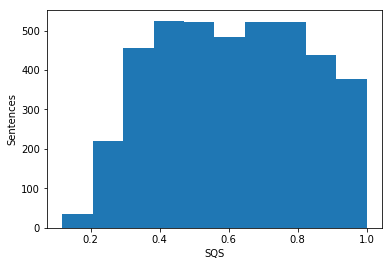

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(processed_results["units"]["uqs"])
plt.xlabel("SQS")
plt.ylabel("Sentences")

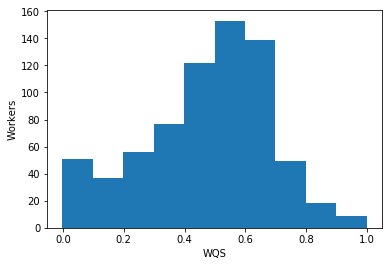

In [6]:
plt.hist(processed_results["workers"]["wqs"])
plt.xlabel("WQS")
plt.ylabel("Workers")

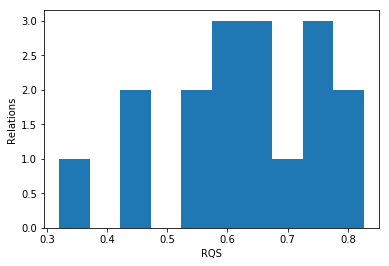

In [7]:
plt.hist(processed_results["annotations"]["aqs"])
plt.xlabel("RQS")
plt.ylabel("Relations")

In [8]:
processed_results["annotations"]["aqs"]

none                              0.643031
org:alternate_names               0.751094
org:place_of_headquarters         0.523691
org:subsidiaries                  0.563459
per:cause_of_death                0.640269
per:charges                       0.754365
per:children                      0.826457
per:employee_or_member_of         0.433373
per:founded_org                   0.602700
per:origin                        0.320860
per:place_of_birth                0.736764
per:place_of_death                0.633270
per:places_of_residence           0.441318
per:schools_attended              0.593955
per:spouse                        0.812720
per:title                         0.600670
per:top_member_employee_of_org    0.716420
Name: aqs, dtype: float64

In [9]:
import operator

dlist = []
max_frame = []
max_fss = []
for idx in processed_results["units"].index:
    if idx != "unit_annotation_score":
        aux_dict = { k:v for k, v in processed_results["units"]["unit_annotation_score"][idx].iteritems() if v }
        dlist.append(aux_dict)
        max_frame.append(max(aux_dict.iteritems(), key=operator.itemgetter(1))[0])
        max_fss.append(max(aux_dict.values()))

processed_results["units"]["SRS"] = pd.Series(dlist, index=processed_results["units"].index)
processed_results["units"]["max_rel"] = pd.Series(max_frame, index=processed_results["units"].index)
processed_results["units"]["max_srs"] = pd.Series(max_fss, index=processed_results["units"].index)

processed_results["units"].to_csv("od_relex_sentences.csv")
processed_results["workers"].to_csv("od_relex_workers.csv")

In [27]:
relations = list(processed_results["annotations"].index)
for rel in relations:
    processed_results["units"][rel] = 0.0

#processed_results["units"]["SRS"]["301KG0KX9CXSYWVXYIGKVMSJFHVH2F"]["none"]

for idx in processed_results["units"].index:
    for rel in relations:
        if rel in processed_results["units"]["SRS"][idx].keys():
            processed_results["units"].at[idx, rel] = max(0.0, processed_results["units"]["SRS"][idx][rel])

In [28]:
processed_results["units"].to_csv("od_relex_sentences.csv")
processed_results["workers"].to_csv("od_relex_workers.csv")

In [10]:
relations = list(pre_processed_results["annotations"].index)
for rel in relations:
    pre_processed_results["judgments"][rel] = 0.0
for idx in pre_processed_results["judgments"].index:
    for rel in relations:
        if rel in pre_processed_results["judgments"]["output.rellist"][idx].keys():
            pre_processed_results["judgments"].at[idx, rel] = max(
                0.0, pre_processed_results["judgments"]["output.rellist"][idx][rel])

In [12]:
pre_processed_results["judgments"].to_csv("worker_judgments.csv")